In [1]:
import pandas as pd

# df = pd.read_parquet("data/oxford-iiit-pet/initial_samples.parquet")
df = pd.read_parquet("active_labeled.parquet")
df


filepath              label
0          data/oxford-iiit-pet/20/Maine_Coon_100.jpg         maine_coon
1          data/oxford-iiit-pet/20/Maine_Coon_136.jpg         maine_coon
2          data/oxford-iiit-pet/20/Maine_Coon_131.jpg         maine_coon
3          data/oxford-iiit-pet/20/Maine_Coon_201.jpg         maine_coon
4          data/oxford-iiit-pet/20/Maine_Coon_171.jpg         maine_coon
..                                                ...                ...
607             data/oxford-iiit-pet/6/Birman_187.jpg             birman
608        data/oxford-iiit-pet/20/Maine_Coon_193.jpg         maine_coon
609  data/oxford-iiit-pet/9/British_Shorthair_149.jpg  british_shorthair
610             data/oxford-iiit-pet/6/Birman_153.jpg             birman
611              data/oxford-iiit-pet/8/boxer_122.jpg              boxer

[612 rows x 2 columns]

In [2]:
df["label"].value_counts()

label
russian_blue                  40
bengal                        27
abyssinian                    27
british_shorthair             23
bombay                        23
sphynx                        23
maine_coon                    22
birman                        20
shiba_inu                     19
beagle                        18
boxer                         17
staffordshire_bull_terrier    16
havanese                      16
ragdoll                       16
chihuahua                     16
leonberger                    16
american_pit_bull_terrier     16
japanese_chin                 15
english_setter                15
american_bulldog              15
miniature_pinscher            15
siamese                       14
english_cocker_spaniel        14
persian                       13
saint_bernard                 13
wheaten_terrier               13
pomeranian                    13
yorkshire_terrier             13
egyptian_mau                  13
german_shorthaired            12
kees

In [3]:
import timm
timm.list_models("convnext*")

['convnext_atto',
 'convnext_atto_ols',
 'convnext_atto_rms',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnext_zepto_rms',
 'convnext_zepto_rms_ols',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [4]:
from active_vision import ActiveLearner
from fastai.vision.models.all import resnet18

al = ActiveLearner("convnextv2_atto")

2025-01-14 13:21:36.599 | INFO     | active_vision.core:load_model:34 - Loading timm model convnextv2_atto


In [5]:
al.load_dataset(df, filepath_col="filepath", label_col="label", batch_size=64)

2025-01-14 13:21:36.623 | INFO     | active_vision.core:load_dataset:46 - Loading dataset from filepath and label
2025-01-14 13:21:36.624 | INFO     | active_vision.core:load_dataset:49 - Creating dataloaders
2025-01-14 13:21:37.117 | INFO     | active_vision.core:load_dataset:62 - Creating learner
2025-01-14 13:21:37.912 | INFO     | active_vision.core:load_dataset:65 - Done. Ready to train.


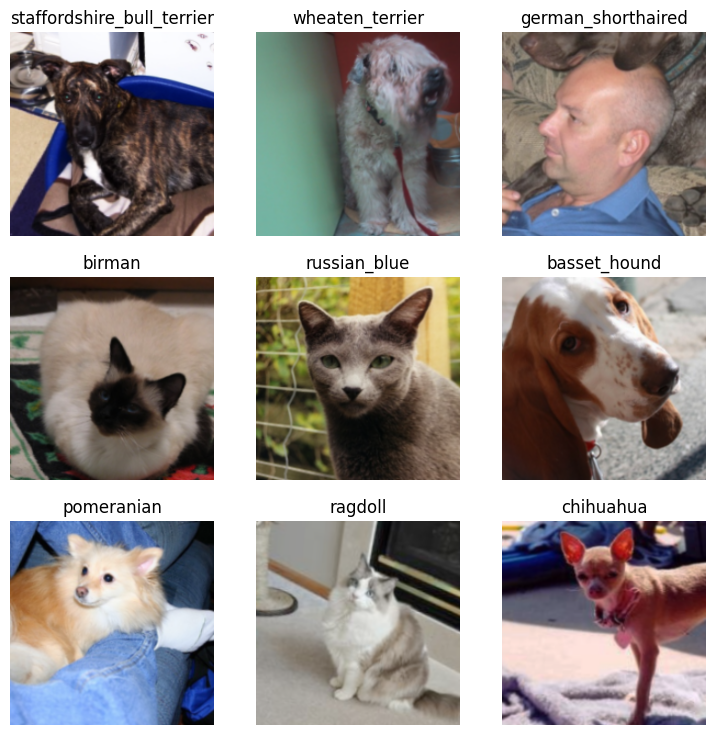

In [6]:
al.show_batch()

In [7]:
al.train_set

filepath              label
0          data/oxford-iiit-pet/20/Maine_Coon_100.jpg         maine_coon
1          data/oxford-iiit-pet/20/Maine_Coon_136.jpg         maine_coon
2          data/oxford-iiit-pet/20/Maine_Coon_131.jpg         maine_coon
3          data/oxford-iiit-pet/20/Maine_Coon_201.jpg         maine_coon
4          data/oxford-iiit-pet/20/Maine_Coon_171.jpg         maine_coon
..                                                ...                ...
607             data/oxford-iiit-pet/6/Birman_187.jpg             birman
608        data/oxford-iiit-pet/20/Maine_Coon_193.jpg         maine_coon
609  data/oxford-iiit-pet/9/British_Shorthair_149.jpg  british_shorthair
610             data/oxford-iiit-pet/6/Birman_153.jpg             birman
611              data/oxford-iiit-pet/8/boxer_122.jpg              boxer

[612 rows x 2 columns]

In [8]:
al.lr_find()

2025-01-14 13:21:38.819 | INFO     | active_vision.core:lr_find:71 - Finding optimal learning rate


2025-01-14 13:21:56.903 | INFO     | active_vision.core:lr_find:73 - Optimal learning rate: 0.0014454397605732083


In [10]:
al.train(epochs=10, lr=1e-3)

2025-01-14 13:22:31.873 | INFO     | active_vision.core:train:76 - Training for 10 epochs with learning rate: 0.001


## Evaluate the model on a *labeled* evaluation set

In [11]:
evaluation_df = pd.read_parquet("data/oxford-iiit-pet/evaluation_samples.parquet")
al.evaluate(evaluation_df, filepath_col="filepath", label_col="label")


2025-01-14 13:23:05.599 | INFO     | active_vision.core:evaluate:118 - Accuracy: 84.44%


0.8443717634232761

## Get the predictions from an *unlabeled* set

In [ ]:
df = pd.read_parquet("data/oxford-iiit-pet/unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

In [ ]:
pred_df = al.predict(filepaths, batch_size=128)
pred_df

In [ ]:
uncertain_df = al.sample_uncertain(pred_df, num_samples=100)
uncertain_df

## Label the uncertain samples

In [ ]:
al.label(uncertain_df, output_filename="uncertain")

In [ ]:
labeled_df = pd.read_parquet("uncertain.parquet")

labeled_df


In [ ]:
al.add_to_train_set(labeled_df, output_filename="active_labeled")